<a href="https://colab.research.google.com/github/tombackert/ml-stuff/blob/main/lime_captum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [6]:
# imports
import torch
import torch.nn.functional as F

from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso

import os
import json

In [9]:
from torchvision.models import resnet18
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T
from captum.attr._core.lime import get_exp_kernel_similarity_function

from PIL import Image
import matplotlib.pyplot as plt

In [10]:
# model
resnet = resnet18(pretrained=True)
resent = resnet.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.6MB/s]


In [11]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2024-05-03 12:19:27--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.232.216, 52.217.224.8, 54.231.225.0, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.232.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/root/.torch/models/imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.001s  

2024-05-03 12:19:27 (26.9 MB/s) - ‘/root/.torch/models/imagenet_class_index.json’ saved [35363/35363]



In [12]:
labels_path = os.getenv('HOME') + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = {idx: label for idx, [_, label] in json.load(json_data).items()}

In [18]:
voc_ds = VOCSegmentation(
    './VOC',
    year='2012',
    image_set='train',
    download=True,
    transform=T.Compose([
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    target_transform=T.Lambda(
        lambda p: torch.tensor(p.getdata()).view(1, p.size[1], p.size[0])
    )
)

100%|██████████| 1999639040/1999639040 [00:56<00:00, 35628630.65it/s]


Extracting ./VOC/VOCtrainval_11-May-2012.tar to ./VOC


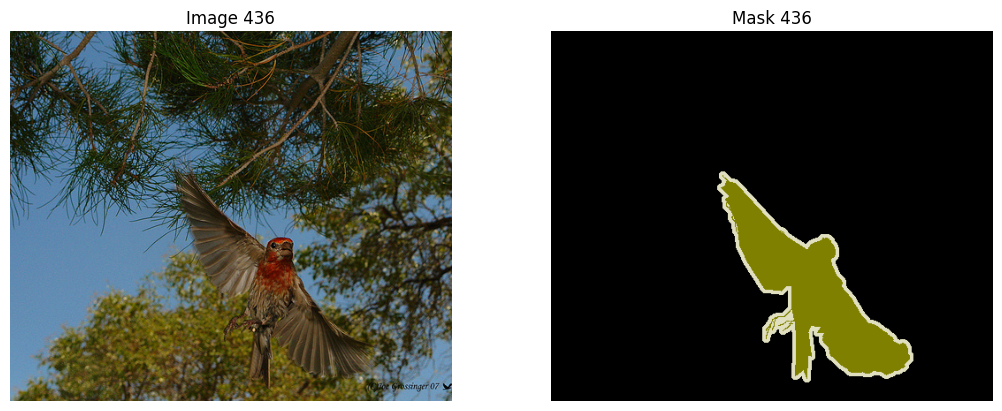

In [22]:
sample_idx = 436

def show_image(ind):
    fig, ax = plt.subplots(1, 2, figsize=[6.4 * 2, 4.8])
    for i, (name, source) in enumerate(zip(['Image', 'Mask'], [voc_ds.images, voc_ds.masks])):
        ax[i].imshow(Image.open(source[ind]));
        ax[i].set_title(f"{name} {ind}")
        ax[i].axis('off')

show_image(sample_idx)

In [23]:
img, seg_mask = voc_ds[sample_idx]  # tensors of shape (channel, hight, width)

outputs = resnet(img.unsqueeze(0))
output_probs = F.softmax(outputs, dim=1).squeeze(0)

In [24]:
def print_result(probs, topk=1):
    probs, label_indices = torch.topk(probs, topk)
    probs = probs.tolist()
    label_indices = label_indices.tolist()
    for prob, idx in zip(probs, label_indices):
        label = idx_to_labels[str(idx)]
        print(f'{label} ({idx}):', round(prob, 4))

print_result(output_probs, topk=5)

house_finch (12): 0.0592
bald_eagle (22): 0.0574
sulphur-crested_cockatoo (89): 0.041
vulture (23): 0.0352
kite (21): 0.0298


In [25]:
#lime
seg_ids = sorted(seg_mask.unique().tolist())
print('Segmentation IDs:', seg_ids)

# map segment IDs to feature group IDs
feature_mask = seg_mask.clone()
for i, seg_id in enumerate(seg_ids):
    feature_mask[feature_mask == seg_id] = i

print('Feature mask IDs:', feature_mask.unique().tolist())

Segmentation IDs: [0, 3, 255]
Feature mask IDs: [0, 1, 2]


In [26]:
# configure lime
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

lr_lime = Lime(
    resnet,
    interpretable_model=SkLearnLinearRegression(),
    similarity_func=exp_eucl_distance
)

In [47]:
# training lime
label_idx = output_probs.argmax().unsqueeze(0)
attrs = lr_lime.attribute(
    img.unsqueeze(0),
    target=label_idx,
    feature_mask=feature_mask.unsqueeze(0),
    n_samples=40,
    perturbations_per_eval=16,
    show_progress=True,
    return_input_shape=True
)

print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())

Lime attribution:   0%|          | 0/3 [00:00<?, ?it/s]

Attribution range: -0.004037141799926758 to 4.282620429992676


In [44]:
attrs.shape

torch.Size([3, 419, 500])

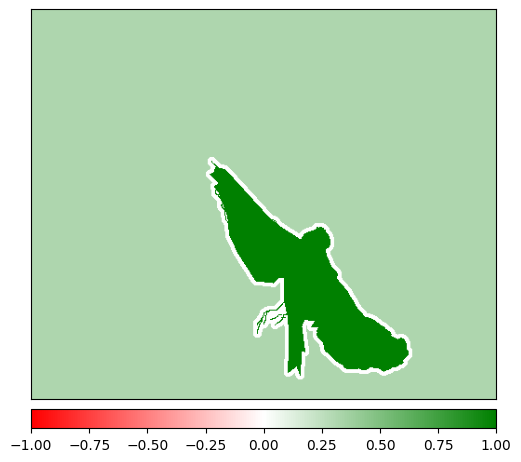

In [45]:
def show_attr(attr_map):
    viz.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

show_attr(attrs)

In [38]:
n_interpret_features = len(seg_ids)

def iter_combinations(*args, **kwargs):
    for i in range(2 ** n_interpret_features):
        yield torch.tensor([int(d) for d in bin(i)[2:].zfill(n_interpret_features)]).unsqueeze(0)

lasso_lime = Lime(
    resnet,
    interpretable_model=SkLearnLasso(alpha=0.08),
    similarity_func=exp_eucl_distance,
    perturb_func=iter_combinations
)

attrs = lasso_lime.attribute(
    img.unsqueeze(0),
    target=label_idx,
    feature_mask=feature_mask.unsqueeze(0),
    n_samples=2 ** n_interpret_features,
    perturbations_per_eval=16,
    show_progress=True,
    return_input_shape=True
).squeeze(0)

print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())

Lime attribution:   0%|          | 0/1 [00:00<?, ?it/s]

Attribution range: 0.0 to 3.7941625118255615


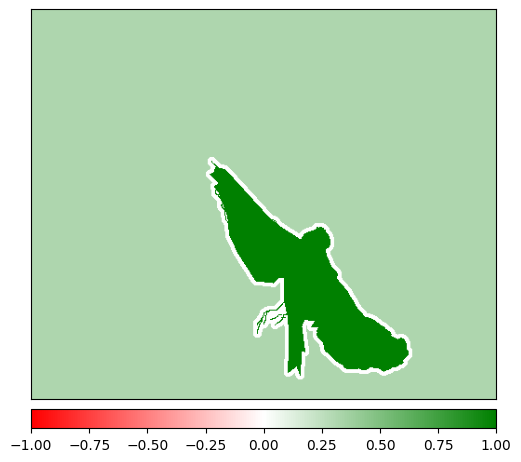

In [46]:
def show_attr(attr_map):
    viz.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels
        method='heat_map',
        sign='all',
        show_colorbar=True
    )


show_attr(attrs)